<h2>Abstract</h2>
<p>
このノートブックでは、以下のKaggleのデータセットで公開されている男子プロテニスの試合結果データを使って、各選手の強さをベイズでモデル化してみます。<br>
データセットには様々な得点情報なども含まれていますが、今回は、開催した年と、勝ったか負けたか、その時の勝ちプレイヤー、負けプレイヤーの情報だけで、各プレイヤーの強さを分析してみます。<br>
<br>
男子プロテニスの試合結果データセット: <a href="https://www.kaggle.com/datasets/gmadevs/atp-matches-dataset">https://www.kaggle.com/datasets/gmadevs/atp-matches-dataset</a><br>
<br>
各選手はそれぞれ本来の強さ（潜在的な強さ）を持っていると考えられます。<br>
しかし、試合ごとに見れば、調子が良くてパフォーマンスを発揮できたという時もあれば、不調で本来の力を出すことができなかった時などもあり、これを、力を発揮できたりできなかったりの”勝負時のムラ”として考えます。<br>
勝負の結果はパフォーマンスの大小で決まる（大きかった方が勝つ）と考えます。<br>
これをベイズモデル化することで、各選手において、その選手が持っている潜在的な強さ、および、その選手が持っている勝負のムラを推定することができます。<br>
<br>
分析は Part A と Part B の二部構成で分けて分析しています。<br>
Part A では、ある期間における各プレイヤーの勝ち負けの情報を使って、その期間におけるプレイヤー本来の強さと勝負のムラを推定してみます。<br>
Part B では、Part A の分析に状態空間モデルの考え方を取り入れて拡張し、プレイヤーの本来の強さ・勝負のムラが時系列でどのように推移しているのかを推定してみます。<br>
<br>
なお、今回の分析は以下の本の一部内容（第6章）として詳細を再掲し出版されています。<br>
<br>
<a href="https://www.amazon.co.jp/%E3%81%9F%E3%81%AE%E3%81%97%E3%81%84%E3%83%99%E3%82%A4%E3%82%BA%E3%83%A2%E3%83%87%E3%83%AA%E3%83%B3%E3%82%B02-%E4%BA%8B%E4%BE%8B%E3%81%A7%E6%8B%93%E3%81%8F%E7%A0%94%E7%A9%B6%E3%81%AE%E3%83%95%E3%83%AD%E3%83%B3%E3%83%86%E3%82%A3%E3%82%A2-%E8%B1%8A%E7%94%B0-%E7%A7%80%E6%A8%B9/dp/4762830836">"たのしいベイズモデリング2: 事例で拓く研究のフロンティア"</a><br>
<br>
==============<br>
<br>
In this notebook, tried to the bayes modeling of latent strength of each men's pro-tennis player using the following kaggle dataset which include a result of men's pro-tennis matches.<br>
This dataset includes various detail information such as score, however I will analyze using only year of match, winner and loser.<br>
<br>
Used dataset: <a href="https://www.kaggle.com/datasets/gmadevs/atp-matches-dataset">https://www.kaggle.com/datasets/gmadevs/atp-matches-dataset</a><br>
<br>
It seems like that each pro-tennis player has their potential strength (latent strength).<br>
On the other hand, it seems like that sometimes they could perform full potential due to they were good condition, and sometimes they couldn't perform well due to they were not good condition. So we can recognize this as their "uneven performance".<br>
It can consider that the result of the match is determined by which performance is bigger. (bigger will win).<br>
It can estimate each player's latent strength and uneven performance using a bayesian modeling.<br>
<br>
The analysis is divided into two parts, Part A and Part B.<br>
In Part A, using information of each player's wins and losses during a target period, tried to estimate the player's latent strength and uneven performance in the period.<br>
In Part B, extended the analysis of Part A by incorporating the state space modeling, estimated how changed the player's latent strength and uneven performance on time series.<br>
<br>
This analysis has been republished in detail as part of the following book (Chapter 6).<br>
<br>
<a href="https://www.amazon.co.jp/%E3%81%9F%E3%81%AE%E3%81%97%E3%81%84%E3%83%99%E3%82%A4%E3%82%BA%E3%83%A2%E3%83%87%E3%83%AA%E3%83%B3%E3%82%B02-%E4%BA%8B%E4%BE%8B%E3%81%A7%E6%8B%93%E3%81%8F%E7%A0%94%E7%A9%B6%E3%81%AE%E3%83%95%E3%83%AD%E3%83%B3%E3%83%86%E3%82%A3%E3%82%A2-%E8%B1%8A%E7%94%B0-%E7%A7%80%E6%A8%B9/dp/4762830836">"Exciting Bayes modeling 2: Frontiers of research opened by cases"</a><br>
<br>
</p>

<h2>Library</h2>

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pylab as plt
import pystan

<h2>Part A</h2>
<h2>男子プロテニスの対戦データから選手の潜在的な強さをモデル化する</h2>

* 各選手の潜在的な強さモデル
    * 対象選手は、データ数を確認しながら手動で選択
    * 対象期間は、2015〜2017.02頃（直近期間）の戦績
    * 統計モデル
$$performance[g,1]{\sim}Normal(\mu[Loser], \sigma_{pf}[Loser]), \hspace{1em} g=1{\ldots}G$$
$$performance[g,2]{\sim}Normal(\mu[Winner], \sigma_{pf}[Winner]), \hspace{1em} g=1{\ldots}G$$
$$performance[g,1] < performance[g,2], \hspace{1em} g=1{\ldots}G$$
$$\mu[n]{\sim}Normal(0, \sigma_\mu), \hspace{1em} n=1{\ldots}N$$
$$\sigma_{pf}[n]{\sim}Gamma(10, 10), \hspace{1em} n=1{\ldots}N$$
        * $Loser$ : 負けたプレイヤーのインデックス
        * $Winner$ : 勝ったプレイヤーのインデックス
        * 各選手の強さを $\mu[n]$, 勝負ムラを $\sigma_{pf}[n]$ とする
        * 1回の勝負で発揮する力（パフォーマンス）は、平均 $\mu[n]$ , 標準偏差 $\sigma_{pf}[n]$ の正規分布から生成されると考える
        * 勝負の結果はパフォーマンスの大小で決まる（大きかった方が勝つ）
        
<br>
==============<br>
<br>
<h2>Modeling the latent strength and uneven performance of each men's pro-tennis player</h2>

* The model of player's latent strength
    * Target players are selected manually while checking the number of data
    * Target term is 2015 〜 2017.02
    * Bayes model
$$performance[g,1]{\sim}Normal(\mu[Loser], \sigma_{pf}[Loser]), \hspace{1em} g=1{\ldots}G$$
$$performance[g,2]{\sim}Normal(\mu[Winner], \sigma_{pf}[Winner]), \hspace{1em} g=1{\ldots}G$$
$$performance[g,1] < performance[g,2], \hspace{1em} g=1{\ldots}G$$
$$\mu[n]{\sim}Normal(0, \sigma_\mu), \hspace{1em} n=1{\ldots}N$$
$$\sigma_{pf}[n]{\sim}Gamma(10, 10), \hspace{1em} n=1{\ldots}N$$
        * $Loser$ : Index of lose player
        * $Winner$ : Index of win player
        * Player $n$ 's latent strength be $\mu[n]$, uneven performance be $\sigma_{pf}[n]$ .
        * Performance in one match is generated from a normal distribution with mean $\mu[n]$ , standard deviation $\sigma_{pf}[n]$.
        * The result of the match is determined by which performance is bigger. (bigger will win).

<br>

<h2>(A.1) Constants</h2>

In [2]:
START_YEAR = 2015
ARR_TARGET_PLAYER = np.array([
    'Roger Federer',
    'Rafael Nadal',
    'Novak Djokovic',
    'Andy Murray',
    'Stanislas Wawrinka',
    'Juan Martin Del Potro',
    'Milos Raonic',
    'Kei Nishikori',
    'Gael Monfils',
    'Tomas Berdych',
    'Jo Wilfried Tsonga',
    'David Ferrer',
    'Richard Gasquet',
    'Marin Cilic',
    'Grigor Dimitrov',
    'Dominic Thiem',
    'Nick Kyrgios',
    'Alexander Zverev'
])
N_ITER = 1000
N_CHAINS = 4

<h2>(A.2) Functions</h2>

In [3]:
def read_data():
    """Read raw data."""
    cols = [
        'tourney_id', # Id of Tournament
        'tourney_name', # Name of the Tournament
        'surface', # Surface of the Court (Hard, Clay, Grass)
        'draw_size', # Number of people in the tournament
        'tourney_level', # Level of the tournament (A=ATP Tour, D=Davis Cup, G=Grand Slam, M=Masters)
        'tourney_date', # Start date of tournament
        'match_num', # Match number
        'winner_id', # Id of winner
        'winner_seed', # Seed of winner
        'winner_entry', # How the winner entered the tournament
        'winner_name', # Name of winner
        'winner_hand', # Dominant hand of winner (L=Left, R=Right, U=Unknown?)
        'winner_ht', # Height in cm of winner
        'winner_ioc', # Country of winner
        'winner_age', # Age of winner
        'winner_rank', # Rank of winner
        'winner_rank_points', # Rank points of winner
        'loser_id', # Id of loser
        'loser_seed', # Seed of loser
        'loser_entry', # How the loser entered the tournament
        'loser_name', # Name of loser
        'loser_hand', # Dominant hand of loser (L=Left, R=Right, U=Unknown?)
        'loser_ht', # Height in cm of loser
        'loser_ioc', # Country of loser
        'loser_age', # Age of loser
        'loser_rank', # Rank of loser
        'loser_rank_points', # Rank points of loser
        'score', # Score
        'best_of', # Best of X number of sets
        'round', # Round
        'minutes', # Match length in minutes
        'w_ace', # Number of aces for winner
        'w_df', # Number of double faults for winner
        'w_svpt', # Number of service points played by winner
        'w_1stIn', # Number of first serve in for winner
        'w_1stWon', # Number of first serve points won for winner
        'w_2ndWon', # Number of second serve points won for winner
        'w_SvGms', # Number of service games played by winner
        'w_bpSaved', # Number of break points saved by winner
        'w_bpFaced', # Number of break points faced by winner
        'l_ace', # Number of aces for loser
        'l_df', # Number of double faults for loser
        'l_svpt', # Number of service points played by loser
        'l_1stIn', # Number of first serve in for loser
        'l_1stWon', # Number of first serve points won for loser
        'l_2ndWon', # Number of second serve points won for loser
        'l_SvGms', # Number of service games played by loser
        'l_bpSaved', # Number of break points saved by loser
        'l_bpFaced', # Number of break points faced by loser
    ]
    df_matches = pd.concat([
        pd.read_csv('../input/atp_matches_2000.csv', usecols=cols),
        pd.read_csv('../input/atp_matches_2001.csv', usecols=cols),
        pd.read_csv('../input/atp_matches_2002.csv', usecols=cols),
        pd.read_csv('../input/atp_matches_2003.csv', usecols=cols),
        pd.read_csv('../input/atp_matches_2004.csv', usecols=cols),
        pd.read_csv('../input/atp_matches_2005.csv', usecols=cols),
        pd.read_csv('../input/atp_matches_2006.csv', usecols=cols),
        pd.read_csv('../input/atp_matches_2007.csv', usecols=cols),
        pd.read_csv('../input/atp_matches_2008.csv', usecols=cols),
        pd.read_csv('../input/atp_matches_2009.csv', usecols=cols),
        pd.read_csv('../input/atp_matches_2010.csv', usecols=cols),
        pd.read_csv('../input/atp_matches_2011.csv', usecols=cols),
        pd.read_csv('../input/atp_matches_2012.csv', usecols=cols),
        pd.read_csv('../input/atp_matches_2013.csv', usecols=cols),
        pd.read_csv('../input/atp_matches_2014.csv', usecols=cols),
        pd.read_csv('../input/atp_matches_2015.csv', usecols=cols),
        pd.read_csv('../input/atp_matches_2016.csv', usecols=cols),
        pd.read_csv('../input/atp_matches_2017.csv', usecols=cols),
    ])
    
    # Small preprocess
    df_matches = df_matches.dropna(subset=['tourney_date'])
    df_matches['year'] = df_matches['tourney_date'].apply(lambda x: int(str(x)[0:4]))
    df_matches = df_matches.drop(columns="tourney_date")

    return df_matches


def plot_n_match_win_rate(df, arr_target_player):
    """Plot the number of matchs and win rates for each players.
    
    Args:
        df (pd.DataFrame): df_matches.
        arr_target_player (np.ndarray): Target player list.
    """
    arr_cnt = []
    arr_rate = []
    for player in arr_target_player:
        cnt_win = len(df[df['winner_name'] == player])
        cnt_lose = len(df[df['loser_name'] == player])
        arr_cnt.append(cnt_win + cnt_lose)
        arr_rate.append(cnt_win / (cnt_win + cnt_lose))

    fig, axs = plt.subplots(ncols=2, figsize=(15, 5))

    axs[0].bar(x=arr_target_player, height=arr_cnt, color='b', alpha=0.5)
    axs[0].set(xlabel='player', ylabel='cnt')
    for tick in axs[0].get_xticklabels():
        tick.set_rotation(75)
    axs[0].set_title("Plot the number of matches")

    axs[1].bar(x=arr_target_player, height=arr_rate, color='r', alpha=0.5)
    axs[1].set(xlabel='player', ylabel='rate')
    for tick in axs[1].get_xticklabels():
        tick.set_rotation(75)
    axs[1].set_title("Plot the rate of win")

    plt.show()


def get_dict_target(arr_target):
    """Get dictionary of value of arr_target to number.
    
    Args:
        arr_target (np.ndarray): List.
    
    Returns:
        dic_target (dict[str, int]): Dictionary.
    """
    dic_target = {}
    for v in arr_target:
        if v not in dic_target:
            dic_target[v] = len(dic_target) + 1

    return dic_target


def get_lw(df, arr_target_player, dic_target_player):
    """Get LW data for input model.
    
    Args:
        df (pd.DataFrame): df_matches.
        arr_target_player (np.ndarray): Target player list.
        dic_target_player (dict[str, int]): Dictionary of player to number.
    
    Returns:
        np.ndarray: LW array.
    """
    LW = []
    for player_a in arr_target_player:
        for player_b in arr_target_player:

            df_tmp = df[
                (df['winner_name'] == player_a) &
                (df['loser_name'] == player_b)
            ]
            for _ in range(len(df_tmp)):
                LW.append([dic_target_player[player_b], dic_target_player[player_a]])

            df_tmp = df[
                (df['winner_name'] == player_b) &
                (df['loser_name'] == player_a)
            ]
            for _ in range(len(df_tmp)):
                LW.append([dic_target_player[player_a], dic_target_player[player_b]])

    LW = np.array(LW, dtype=np.int32)
    return LW


def train_model(data, n_iter, n_chains):
    """Train the model.
    
    Args:
        data (dict[str, int or np.ndarray]): Input data.
        n_iter (int): The number of iter.
        n_chains (int): The number of chain.
        
    Returns:
        collections.OrderedDict: Result.
    """
    model = """
        data {
            int N;
            int G;
            int<lower=1, upper=N> LW[G, 2];
        }
        parameters {
            ordered[2] performance[G];
            vector<lower=0>[N] mu;
            real<lower=0> s_mu; 
            vector<lower=0>[N] s_pf;
        }
        model {
            for (g in 1:G)
                for (i in 1:2)
                    performance[g, i] ~ normal(mu[LW[g, i]], s_pf[LW[g, i]]);

            mu ~ normal(0, s_mu);
            s_pf ~ gamma(10, 10);
        }
    """
    fit = pystan.stan(model_code=model, data=data, iter=n_iter, chains=n_chains)
    
    return fit.extract()


def plot_chains_dist(arr_target_player, n_chains, la, target_param):
    """Plot distributions of each chains.
    
    Args:
        arr_target_player (np.ndarray): Target player list.
        n_chains (int): The number of chains.
        la (collections.OrderedDict): Result.
        target_param (str): Target latest parameter.
    """
    cmap = matplotlib.cm.get_cmap('tab10')
    
    plt.figure(figsize=(10, 5))
    
    for i, player in enumerate(arr_target_player):
        for j in range(n_chains):
            g = plt.violinplot(
                la[target_param][j * 500:(j + 1) * 500, i], 
                positions=[i], 
                showmeans=False, 
                showextrema=False,
                showmedians=False,
            )
            for pc in g['bodies']:
                pc.set_facecolor(cmap(j))

    plt.legend([f"chain {i + 1}" for i in range(n_chains)])
    plt.xticks(list(range(len(arr_target_player))), arr_target_player)
    plt.xticks(rotation=45)
    plt.xlabel('player')
    plt.ylabel(target_param)
    plt.show()
    
    
def plot_posterior_dist(arr_target_player, la, target_param):
    """Plot posterior distributeion of given latest parameter.
    
    Args:
        arr_target_player (np.ndarray): Target player list.
        la (collections.OrderedDict): Result.
        target_param (str): Target latest parameter.
    """
    cmap = matplotlib.cm.get_cmap('tab10')

    plt.figure(figsize=(15, 7))

    for i, player in enumerate(arr_target_player):
        g = plt.violinplot(
            la[target_param][:, i], 
            positions=[i], 
            showmeans=False,
            showextrema=True, 
            showmedians=True,
        )

        c = cmap(i % 10)
        for pc in g['bodies']:
            pc.set_facecolor(c)    
        g['cbars'].set_edgecolor(c)
        g['cmaxes'].set_edgecolor(c)
        g['cmedians'].set_edgecolor(c)
        g['cmins'].set_edgecolor(c)

    plt.xticks(list(range(len(arr_target_player))), arr_target_player)
    plt.xticks(rotation=45)
    plt.xlabel('player')
    plt.ylabel(target_param)
    plt.show()
    
    
def get_desc_posterior_dist(arr_target_player, n_chains, la, target_param):
    """Get summary of posterior distribution of given latest parameter.
    
    Args:
        arr_target_player (np.ndarray): Target player list.
        n_chains (int): The number of chains.
        la (collections.OrderedDict): Result.
        target_param (str): Target latest parameter.
        
    Returns:
        pd.DataFrame: Dataframe of summary.
    """
    summary = np.zeros((len(arr_target_player), n_chains))

    for i, player in enumerate(arr_target_player):
        samples = la[target_param][:, i]
        median = np.median(samples, axis=0)
        std = np.std(samples, ddof=1)
        lower, upper = np.percentile(samples, q=[25.0, 75.0], axis=0)
        summary[i] = [median, std, lower, upper]

    df_summary = pd.DataFrame(
        summary,
        index=arr_target_player, 
        columns=['median', 'std', '25%', '75%'],
    )
    
    return df_summary

<h2>(A.3) Read data</h2>

In [4]:
df_matches = read_data()

print(df_matches.shape)
display(df_matches.sample(3))

(53508, 49)


,tourney_id,tourney_name,surface,draw_size,tourney_level,match_num,winner_id,winner_seed,winner_entry,winner_name,winner_hand,winner_ht,winner_ioc,winner_age,winner_rank,winner_rank_points,loser_id,loser_seed,loser_entry,loser_name,loser_hand,loser_ht,loser_ioc,loser_age,loser_rank,loser_rank_points,score,best_of,round,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,year
1979,2003-540,Wimbledon,Grass,128.0,G,118.0,103206.0,13.0,NaN,Sebastien Grosjean,R,175.0,FRA,25.067762,14.0,1500.0,103507.0,3.0,NaN,Juan Carlos Ferrero,R,183.0,ESP,23.359343,3.0,3760.0,6-2 4-6 7-6(2) 7-6(3),5.0,R16,195.0,19.0,4.0,142.0,80.0,65.0,30.0,21.0,4.0,7.0,6.0,5.0,143.0,84.0,60.0,29.0,21.0,8.0,12.0,2003
1666,2004-440,'s-Hertogenbosch,Grass,32.0,A,2.0,102306.0,NaN,Q,Michael Kohlmann,R,188.0,GER,30.422998,392.0,73.0,102567.0,NaN,Q,George Bastl,R,183.0,SUI,29.204654,447.0,56.0,7-6(7) 6-4,3.0,R32,93.0,2.0,1.0,69.0,53.0,36.0,11.0,11.0,1.0,2.0,8.0,2.0,85.0,59.0,42.0,11.0,11.0,5.0,7.0,2004
327,2012-311,Queen's Club,Grass,56.0,A,44.0,103900.0,10.0,NaN,David Nalbandian,R,180.0,ARG,30.442163,39.0,1015.0,104273.0,NaN,NaN,Edouard Roger Vasselin,R,188.0,FRA,28.536619,67.0,669.0,4-6 7-5 6-3,3.0,R16,135.0,7.0,14.0,112.0,65.0,47.0,21.0,16.0,6.0,9.0,6.0,5.0,98.0,60.0,44.0,13.0,15.0,3.0,7.0,2012


In [5]:
df_matches["year"].min(), df_matches["year"].max()

(2000, 2017)

<h2>(A.4) Preprocess data</h2>

<h3>(A.4.1) Preprocess raw data</h3>

In [6]:
# Use columns
df_matches = df_matches[["year", "winner_name", "loser_name"]]

# Convert data type
df_matches["year"] = df_matches["year"].astype(int)
df_matches["winner_name"] = df_matches["winner_name"].astype(str)
df_matches["loser_name"] = df_matches["loser_name"].astype(str)

# Extract target player records
df_matches = df_matches[
    (df_matches['year'] >= START_YEAR) &
    (df_matches['winner_name'].isin(ARR_TARGET_PLAYER)) &
    (df_matches['loser_name'].isin(ARR_TARGET_PLAYER))
]

<h3>(A.4.2) Plot the number of matches and win rate for each player</h3>

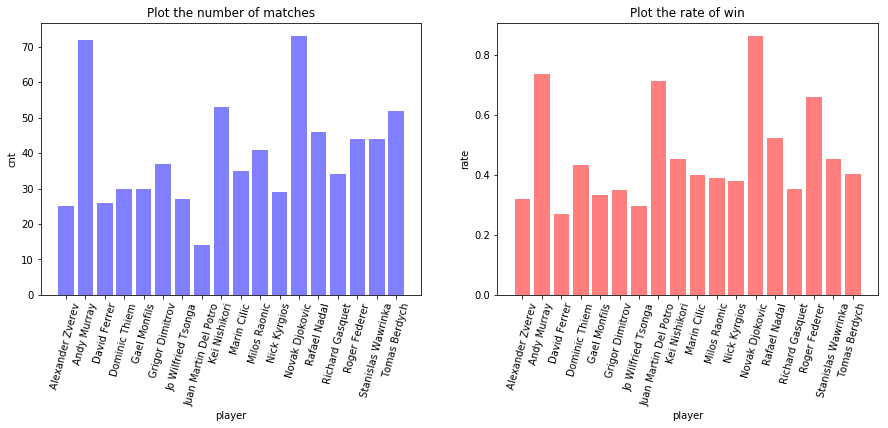

In [7]:
plot_n_match_win_rate(df_matches, ARR_TARGET_PLAYER)

<h3>(A.4.3) Prepare input for the model</h3>

In [8]:
dic_target_player = get_dict_target(ARR_TARGET_PLAYER)
LW = get_lw(df_matches, ARR_TARGET_PLAYER, dic_target_player)

<h2>(A.5) Train the model</h2>

<h3>(A.5.1) Train the model</h3>

In [9]:
data = {"N": len(dic_target_player), "G": len(LW), "LW": LW}
la = train_model(data, N_ITER, N_CHAINS)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d7987ba5e01521e9f3425d543995e19a NOW.


<h3>(A.5.2) Check distributions for each chains</h3>

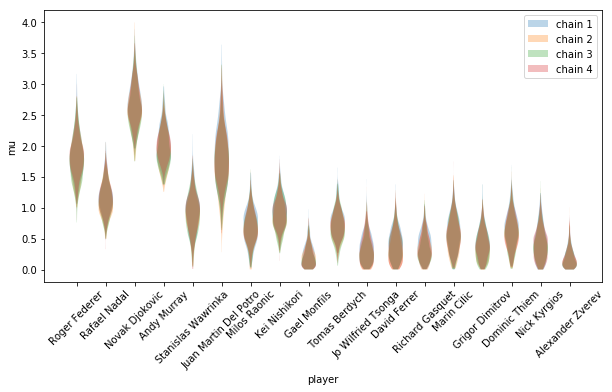

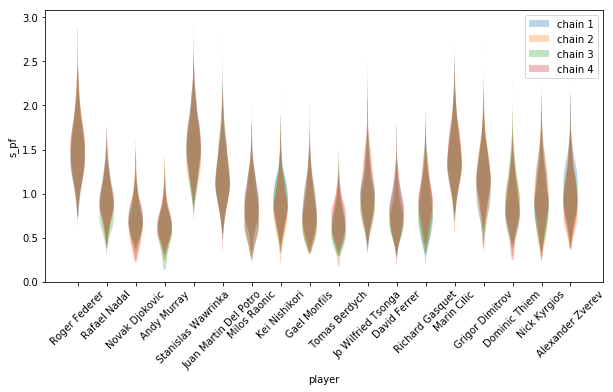

In [10]:
plot_chains_dist(
    arr_target_player=ARR_TARGET_PLAYER, 
    n_chains=N_CHAINS, 
    la=la, 
    target_param="mu",
)
plot_chains_dist(
    arr_target_player=ARR_TARGET_PLAYER, 
    n_chains=N_CHAINS, 
    la=la, 
    target_param="s_pf",
)

<h2>(A.6) Plot posterior distributions</h2>

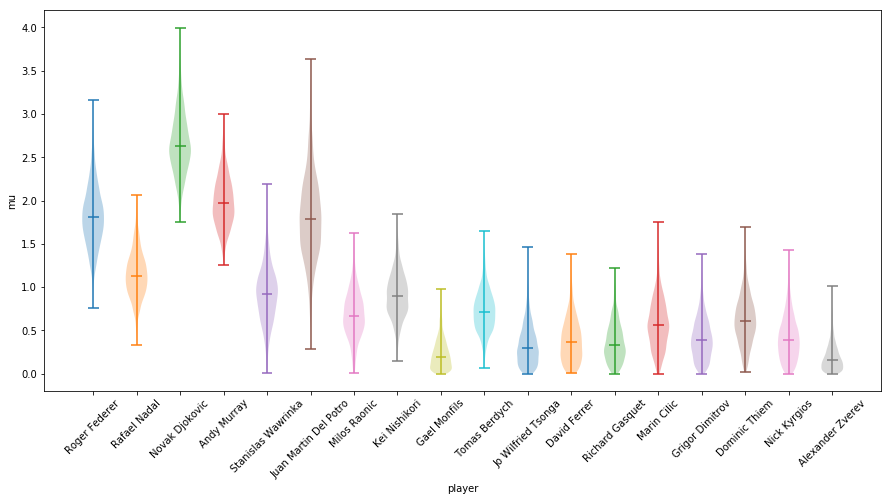

,median,std,25%,75%
Roger Federer,1.808048,0.345134,1.580829,2.034034
Rafael Nadal,1.132177,0.265928,0.962158,1.311908
Novak Djokovic,2.624471,0.353053,2.420583,2.884564
Andy Murray,1.966294,0.291589,1.778461,2.183624
Stanislas Wawrinka,0.919937,0.321141,0.692449,1.115762
Juan Martin Del Potro,1.787607,0.476075,1.476287,2.110170
Milos Raonic,0.669683,0.272358,0.501848,0.859132
Kei Nishikori,0.901462,0.253953,0.728884,1.076622
Gael Monfils,0.193048,0.166922,0.088180,0.323385
Tomas Berdych,0.715379,0.232521,0.558622,0.876802


In [11]:
# Latent strength

target_param = "mu"
plot_posterior_dist(
    arr_target_player=ARR_TARGET_PLAYER, 
    la=la, 
    target_param=target_param,
)
df_s = get_desc_posterior_dist(
    arr_target_player=ARR_TARGET_PLAYER, 
    n_chains=N_CHAINS,
    la=la, 
    target_param=target_param,
)
display(df_s)

<h2>Insights</h2>

* 対象期間は、ジョコビッチ1強時代であったため、ジョコビッチが1番強いと出ている
* デル・ポトロもBIG4に引けを取らない強さ
* ワウリンカと錦織が同じくらいの強さ
* 対象期間中では、若手は中堅以上には若干劣っている様子
* 若手の中では、ティエムが強い

<br>
==============<br>
<br>

* Djokovic is estimated as the strongest in the period
* Del Potro is also strong almost same with BIG4
* Wawrinka and Nishikori are nearly equally strong
* Young players seem to be slightly inferior to the middle-ranked players and above
* Thiem is strong among the young players

<br>

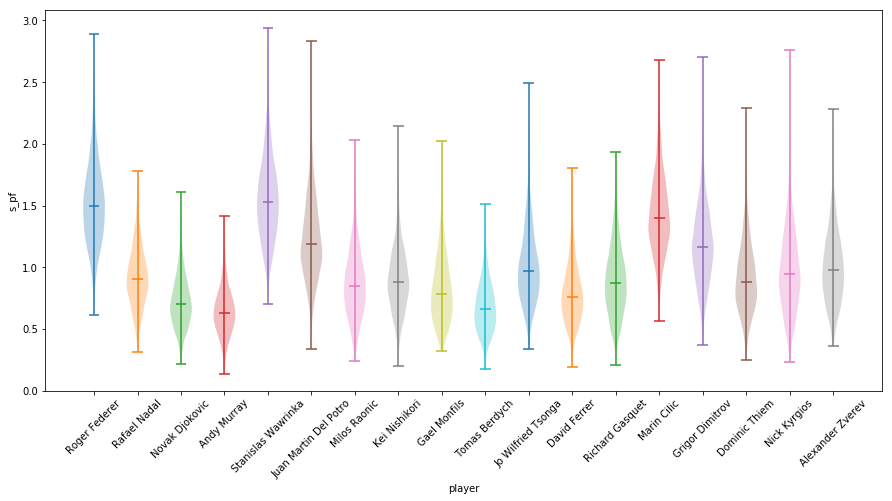

,median,std,25%,75%
Roger Federer,1.496997,0.335395,1.282805,1.726188
Rafael Nadal,0.908310,0.239679,0.761448,1.076250
Novak Djokovic,0.703178,0.215910,0.573888,0.853372
Andy Murray,0.633129,0.197751,0.512633,0.759228
Stanislas Wawrinka,1.532611,0.328857,1.316326,1.760814
Juan Martin Del Potro,1.188408,0.324841,1.004673,1.431784
Milos Raonic,0.849059,0.275000,0.669197,1.039556
Kei Nishikori,0.883867,0.261439,0.723936,1.063055
Gael Monfils,0.784857,0.268243,0.619969,0.992466
Tomas Berdych,0.661959,0.207523,0.529500,0.810981


In [12]:
# Uneven performance

target_param = "s_pf"
plot_posterior_dist(
    arr_target_player=ARR_TARGET_PLAYER, 
    la=la, 
    target_param=target_param,
)
df_s = get_desc_posterior_dist(
    arr_target_player=ARR_TARGET_PLAYER, 
    n_chains=N_CHAINS,
    la=la, 
    target_param=target_param,
)
display(df_s)

<h2>Insights</h2>

* ワウリンカが勝負ムラが一番大きく、BIG4に限らず、同じ選手に勝ったり負けたりしている
* BIG4の中では、この期間では、若干フェデラー、ナダルが勝ったり負けたりが多く、勝負ムラが少し大きめに出ている
* デル・ポトロは、マレー、ワウリンカに1勝1敗で、それ以外は安定して勝っていそうだが、なぜか大きめに出た（データが少ないため？）
* チリッチも、ジョコビッチ、マレーに勝ったことがあり、その他選手とも勝ったり負けたりが多く、勝負ムラが大きく出ている
* 若手選手も全体的に勝負ムラは少し高め、まだパフォーマンスを安定して発揮できていないことが多いということ？

<br>
==============<br>
<br>

* Wawrinka has the largest uneven performance, winning and losing to the same players, not just the BIG4.
* In BIG4, Federer and Nadal have won and lost slightly more often during the period, and the uneven performance of their wins and losses is a little larger.
* Del Potro seems to have won and lost one match against Murray and Wawrinka, and otherwise won consistently, but estimated his uneven performance is large. (due to lack of data?)
* Cilic has wins to Djokovic and Murray, and wins and losses against other players, so his uneven performance is large.
* Uneven performance is a little higher for younger players, meaning that they are often not yet able to perform consistently?

<br>

<h2>##########################################################</h2>

<h2>Part B</h2>
<h2>選手の潜在的な強さに時系列の要素を入れてモデル化する</h2>

* 各選手の潜在的な強さの時系列モデル
    * 対象選手は、データ数を確認しながら手動で選択
    * 対象期間は、2005〜2017.02頃の戦績
    * 統計モデル
$$performance[y][g,1]{\sim}Normal(\mu[Loser][y], \sigma_{pf}[Loser][y]), \hspace{1em} g=1{\ldots}G, y=1{\ldots}Y$$
$$performance[y][g,2]{\sim}Normal(\mu[Winner][y], \sigma_{pf}[Winner][y]), \hspace{1em} g=1{\ldots}G, y=1{\dots}Y$$
$$performance[y][g,1] < performance[y][g,2], \hspace{1em} g=1{\ldots}G, y=1{\ldots}Y$$
$$\mu[n][1]{\sim}Normal(0, \sigma_{\mu}[n][1]), \hspace{1em} n=1{\ldots}N$$
$$\mu[n][y]{\sim}Normal(\mu[n][y-1], \sigma_\mu[n][y-1]), \hspace{1em} n=1{\ldots}N, y=2{\ldots}Y$$
$$\sigma_{pf}[n][y]{\sim}Gamma(10, 10), \hspace{1em} n=1{\ldots}N, y=1{\ldots}Y$$
$$\sigma_\mu[n][y]{\sim}Normal(0, 1), \hspace{1em} n=1{\ldots}N, y=1{\ldots}Y$$
        * $Loser$ : 負けたプレイヤーのインデックス
        * $Winner$ : 勝ったプレイヤーのインデックス
        * 各選手の $y$ 年度の強さを $\mu[n][y]$, 勝負ムラを $\sigma_{pf}[n][y]$ とする
        * $y$ 年度に行われる勝負で発揮する力（パフォーマンス）は、平均 $\mu[n][y]$ , 標準偏差 $\sigma_{pf}[n][y]$ の正規分布から生成されると考える
        * 勝負の結果はパフォーマンスの大小で決まる（大きかった方が勝つ）
        * 各選手のある年度での強さは、その1つ前の年度の強さから生成されると考える
        * 各選手の年度別の強さの変化具合 $\sigma_\mu[n][y]$ は半正規分布に従う
        * 各選手の初年度の強さは平均 $0$ , 標準偏差 $\sigma_{\mu}[n][1]$ の半正規分布に従う
        
<br>
==============<br>
<br>

<h2>Modeling the latent strength and uneven performance of each men's pro-tennis player with a time series</h2>

* Modeling the latent strength and uneven performance for each men's pro-tennis player with a time series
    * Target players are selected manually while checking the number of data
    * Target term is 2005 〜 2017.02
    * Bayes model
$$performance[y][g,1]{\sim}Normal(\mu[Loser][y], \sigma_{pf}[Loser][y]), \hspace{1em} g=1{\ldots}G, y=1{\ldots}Y$$
$$performance[y][g,2]{\sim}Normal(\mu[Winner][y], \sigma_{pf}[Winner][y]), \hspace{1em} g=1{\ldots}G, y=1{\dots}Y$$
$$performance[y][g,1] < performance[y][g,2], \hspace{1em} g=1{\ldots}G, y=1{\ldots}Y$$
$$\mu[n][1]{\sim}Normal(0, \sigma_{\mu}[n][1]), \hspace{1em} n=1{\ldots}N$$
$$\mu[n][y]{\sim}Normal(\mu[n][y-1], \sigma_\mu[n][y-1]), \hspace{1em} n=1{\ldots}N, y=2{\ldots}Y$$
$$\sigma_{pf}[n][y]{\sim}Gamma(10, 10), \hspace{1em} n=1{\ldots}N, y=1{\ldots}Y$$
$$\sigma_\mu[n][y]{\sim}Normal(0, 1), \hspace{1em} n=1{\ldots}N, y=1{\ldots}Y$$
        * $Loser$ : Index of lose player
        * $Winner$ : Index of win player
        * Player $n$ 's latent strength on year $y$ be $\mu[n][y]$, uneven performance be $\sigma_{pf}[n][y]$ .
        * Performance in one match held on year $y$ is generated from a normal distribution with mean $\mu[n][y]$ , standard deviation $\sigma_{pf}[n][y]$ .
        * The result of the match is determined by which performance is bigger. (bigger will win).
        * Consider that each player's strength in a year is generated from the strength in the year before that one.
        * The degree of change in strength of each player by year $\sigma_\mu[n][y]$ follows a half normal distribution.
        * The first-year strength of each player follows a half normal distribution with mean $0$ , standard deviation $\sigma_{\mu}[n][1]$.
        
<br>

<h2>(B.1) Constants</h2>

In [13]:
ARR_TARGET_YEAR = np.array(list(range(2005, 2017)))
ARR_TARGET_PLAYER = np.array([
    'Roger Federer',
    'Rafael Nadal',
    'Novak Djokovic',
    'Andy Murray',
    'Stanislas Wawrinka',
    'Juan Martin Del Potro',
    'Kei Nishikori',
    'Tomas Berdych',
    'David Ferrer',
])
N_ITER = 5000
N_CHAINS = 4

<h2>(B.2) Functions</h2>

In [14]:
def plot_n_match_win_rate_ts(df, arr_target_year, arr_target_player):
    """Plot the number of matchs and win rates for each players on each years.
    
    Args:
        df (pd.DataFrame): df_matches.
        arr_target_year (np.ndarray): Target year list.
        arr_target_player (np.ndarray): Target player list.
    """
    matrix_cnt = np.zeros((len(arr_target_year), len(arr_target_player)), dtype=np.float32)
    matrix_rate = np.zeros((len(arr_target_year), len(arr_target_player)), dtype=np.float32)

    for i, year in enumerate(arr_target_year):
        for j, player in enumerate(arr_target_player):
            cnt_win = len(df[(df['winner_name'] == player) & (df['year'] == year)])
            cnt_lose = len(df[(df['loser_name'] == player) & (df['year'] == year)])
            rate = 0 if (cnt_win + cnt_lose == 0) else cnt_win / (cnt_win + cnt_lose)
            matrix_cnt[i, j] = cnt_win + cnt_lose
            matrix_rate[i, j] = rate

    for j, player in enumerate(arr_target_player):
        if j % 3 == 0:
            fig, axs = plt.subplots(ncols=3, figsize=(15, 3))
        axs[j % 3].plot(arr_target_year, matrix_cnt[:, j], marker='o', color='b', alpha=0.5, label="match num")
        axs[j % 3].set(title=player, xlabel='year', ylabel='cnt', ylim=[0, 40])
        axs[j % 3].legend()

    plt.show()

    for j, player in enumerate(arr_target_player):
        if j % 3 == 0:     
            fig, axs = plt.subplots(ncols=3, figsize=(15, 3))
        axs[j % 3].plot(arr_target_year, matrix_rate[:, j], marker='o', color='r', alpha=0.5, label="win rate")
        axs[j % 3].set(title=player, xlabel='year', ylabel='rate', ylim=[0, 1])
        axs[j % 3].legend()

    plt.show()
    
    
def get_lw_gy(df, arr_target_year, arr_target_player, dic_target_year, dic_target_player):
    """Get LW data and GY data for input model.
    
    Args:
        df (pd.DataFrame): df_matches.
        arr_target_year (np.ndarray): Target year list.
        arr_target_player (np.ndarray): Target player list.
        dic_target_year (dict[int, int]): Dictionary of year to number.
        dic_target_player (dict[str, int]): Dictionary of player to number.
    
    Returns:
        tuple[np.ndarray, np.ndarray]: LW array and GY array.
    """
    LW = []
    GY = []

    for year in arr_target_year:
        for player_a in arr_target_player:
            for player_b in arr_target_player:

                df_tmp = df[
                    (df['year'] == year) &
                    (df['winner_name'] == player_a) &
                    (df['loser_name'] == player_b)
                ]
                for _ in range(len(df_tmp)):
                    LW.append([dic_target_player[player_b], dic_target_player[player_a]])
                    GY.append(dic_target_year[year])

                df_tmp = df[
                    (df['year'] == year) &
                    (df['winner_name'] == player_b) &
                    (df['loser_name'] == player_a)
                ]
                for _ in range(len(df_tmp)):
                    LW.append([dic_target_player[player_a], dic_target_player[player_b]])
                    GY.append(dic_target_year[year])

    LW = np.array(LW, dtype=np.int32)
    GY = np.array(GY, dtype=np.int32)
    return LW, GY


def train_model_ts(data, n_iter, n_chains):
    """Train the model.
    
    Args:
        data (dict[str, int or np.ndarray]): Input data.
        n_iter (int): The number of iter.
        n_chains (int): The number of chains.
    
    Returns:
        collections.OrderedDict: Result.
    """
    model = """
        data {
            int N;
            int G;
            int Y;
            int<lower=1> GY[G];
            int<lower=1, upper=N> LW[G, 2];
        }
        parameters {
            ordered[2] performance[G];
            matrix<lower=0>[N, Y] mu;
            matrix<lower=0>[N, Y] s_mu;
            matrix<lower=0>[N, Y] s_pf;
        }
        model {
            for (g in 1:G)
                for (i in 1:2)
                    performance[g, i] ~ normal(mu[LW[g, i], GY[g]], s_pf[LW[g, i], GY[g]]);

            for (n in 1:N)
                mu[n, 1] ~ normal(0, s_mu[n, 1]);

            for (n in 1:N)
                for (y in 2:Y)
                    mu[n, y] ~ normal(mu[n, y-1], s_mu[n, y]);

            for (n in 1:N)
                s_mu[n] ~ normal(0, 1);

            for (n in 1:N)
                s_pf[n] ~ gamma(10, 10);
        }
    """
    fit = pystan.stan(model_code=model, data=data, iter=n_iter, chains=n_chains)

    return fit.extract()


def plot_posterior_dist_ts(arr_target_year, arr_target_player, la, target_param):
    """Plot posterior distributeion of given latest parameter on each years (time series).
    
    Args:
        arr_target_year (np.ndarray): Target year list.
        arr_target_player (np.ndarray): Target player list.
        la (collections.OrderedDict): Result.
        target_param (str): Target latest parameter.
    """
    cmap = matplotlib.cm.get_cmap('tab10')
    plt.figure(figsize=(15, 7))

    for j, player in enumerate(arr_target_player):
        samples = la[target_param][:, j, :]
        medians = np.median(samples, axis=0)
        lower, upper = np.percentile(samples, q=[25.0, 75.0], axis=0)
        c = cmap(j)
        plt.plot(arr_target_year, medians, marker='o', label=player, color=c)
        plt.fill_between(arr_target_year, lower, upper, alpha=0.2, color=c)

    plt.xlabel('year')
    plt.ylabel(target_param)
    plt.legend(loc='lower left', bbox_to_anchor=(1, 0.5))
    plt.title("Time series of estimated latent strength")
    plt.show()
    
    
def plot_posterior_dist_ts_ply(arr_target_year, arr_target_player, la, target_param):
    """Plot posterior distributeion of given latest parameter on each years.
    
    Args:
        arr_target_year (np.ndarray): Target year list.
        arr_target_player (np.ndarray): Target player list.
        la (collections.OrderedDict): Result.
        target_param (str): Target latest parameter.
    """
    cmap = matplotlib.cm.get_cmap('tab10')

    for j, player in enumerate(arr_target_player):

        if j % 3 == 0:
            fig, axs = plt.subplots(ncols=3, figsize=(15, 3))

        g = axs[j % 3].violinplot(
            la[target_param][:, j, :], 
            positions=arr_target_year, 
            showmeans=False, 
            showextrema=False, 
            showmedians=False,
        )

        c = cmap(j%10)
        for pc in g['bodies']:
            pc.set_facecolor(c)
            pc.set_alpha(0.7)

        axs[j % 3].set(title=player, xlabel='year', ylabel=target_param)

    plt.show()

<h2>(B.3) Read data</h2>

In [15]:
df_matches = read_data()

<h2>(B.4) Preprocess data</h2>

<h3>(B.4.1) Preprocess raw data</h3>

In [16]:
# Use columns
df_matches = df_matches[["year", "winner_name", "loser_name"]]

# Convert data type
df_matches["year"] = df_matches["year"].astype(int)
df_matches["winner_name"] = df_matches["winner_name"].astype(str)
df_matches["loser_name"] = df_matches["loser_name"].astype(str)

# Extract target player records
df_matches = df_matches[
    (df_matches['year'].isin(ARR_TARGET_YEAR)) &
    (df_matches['winner_name'].isin(ARR_TARGET_PLAYER)) &
    (df_matches['loser_name'].isin(ARR_TARGET_PLAYER))
]

<h3>(B.4.2) Plot the number of matches and win rate for each player, time series</h3>

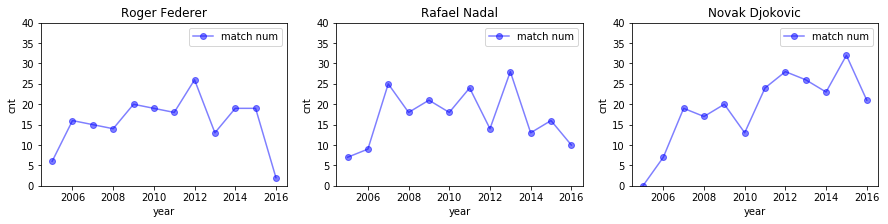

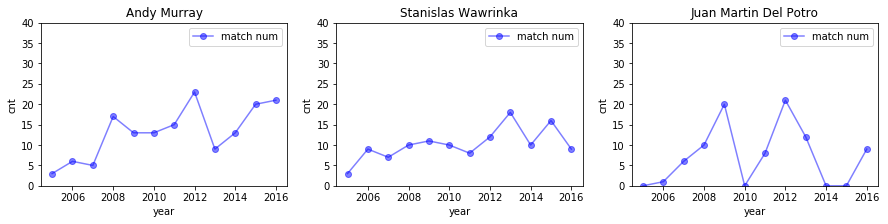

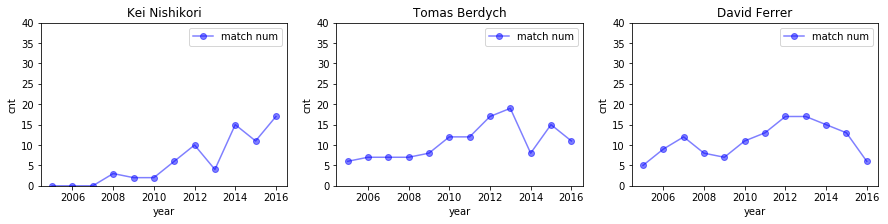

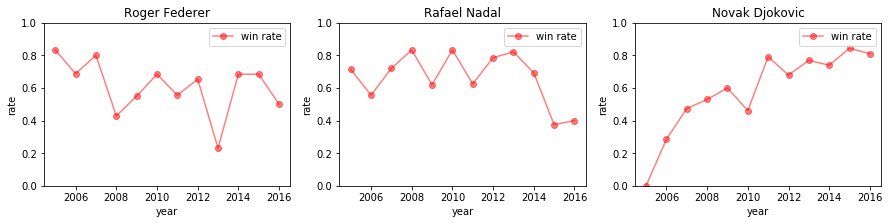

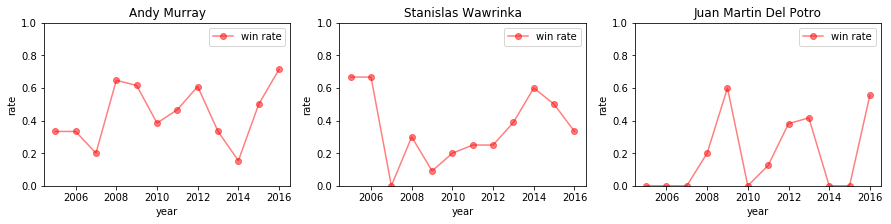

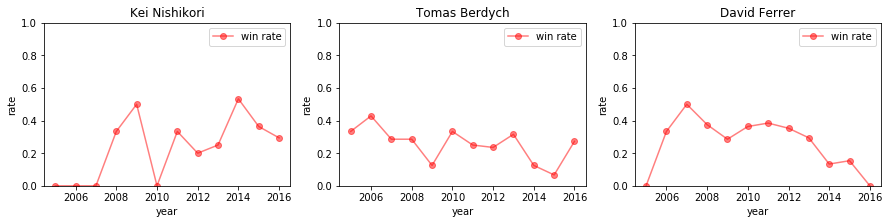

In [17]:
plot_n_match_win_rate_ts(df_matches, ARR_TARGET_YEAR, ARR_TARGET_PLAYER)

<h3>(B.4.3) Prepare input for the model</h3>

In [18]:
dic_target_year = get_dict_target(ARR_TARGET_YEAR)
dic_target_player = get_dict_target(ARR_TARGET_PLAYER)
LW, GY = get_lw_gy(
    df=df_matches,
    arr_target_year=ARR_TARGET_YEAR,
    arr_target_player=ARR_TARGET_PLAYER,
    dic_target_year=dic_target_year,
    dic_target_player=dic_target_player,
)

<h2>(B.5) Train the model</h2>

In [19]:
data = {
    'N': len(dic_target_player),
    'G': len(LW),
    'Y': len(dic_target_year),
    'GY': GY,
    'LW': LW,
}
la_ts = train_model_ts(data=data, n_iter=N_ITER, n_chains=N_CHAINS)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b877751e6d1fcc12e089d0f1e0a8ae13 NOW.


<h2>(B.6) Plot posterior distributions</h2>

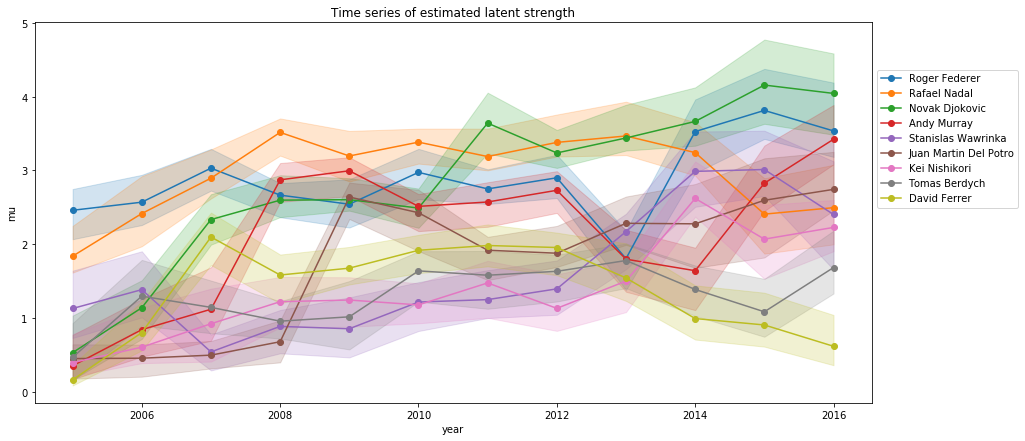

In [20]:
# Latent strength

plot_posterior_dist_ts(
    arr_target_year=ARR_TARGET_YEAR,
    arr_target_player=ARR_TARGET_PLAYER,
    la=la_ts,
    target_param="mu",
)

<h2>Insights</h2>

* 2005年頃は、フェデラー、ナダルの2強時代の様子がよくわかる
* 2008年頃から、フェデラー、ナダルに迫る若手、ジョコビッチ、マレー、デル・ポトロなどの強さの推移がわかる
* 錦織は2014年に強さが急激に上昇（ちなみにこの年に初めて世界ランクTOP10入り）
* デル・ポトロは2009年（初めてグランドスラムに優勝した年）に急激に上昇するも、怪我の影響で推移を落としている様子が見れる
* マレーは2008年頃からフェデラー、ナダルに勝つようになったが、2014年に怪我で不調となっている様子がはっきりと現れた
* フェレール、ベルディヒは停滞している

<br>
==============<br>
<br>

* Around 2005, we can see the two strongest players, Federer and Nadal
* Around 2008, you can see the transition of strength of young players, Djokovic, Murray, Del Potro, etc., who are close to Federer and Nadal
* Nishikori's strength increased dramatically in 2014 (by the way, he entered the top 10 in the year)
* Del Potro increased sharply in 2009 (the year he won his first Grand Slam), but we can see his transition slowing down due to his injuries
* Murray started to beat Federer and Nadal around 2008, but his injury clearly showed his decline in 2014.
* Ferrer and Berdych are stagnating.

<br>

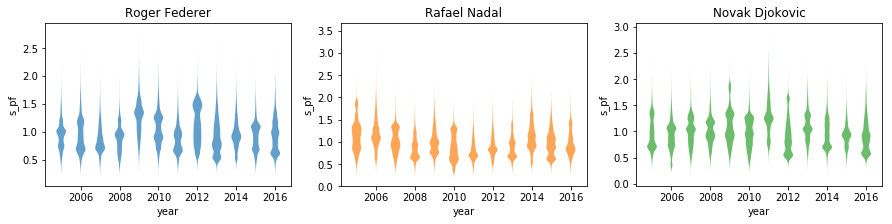

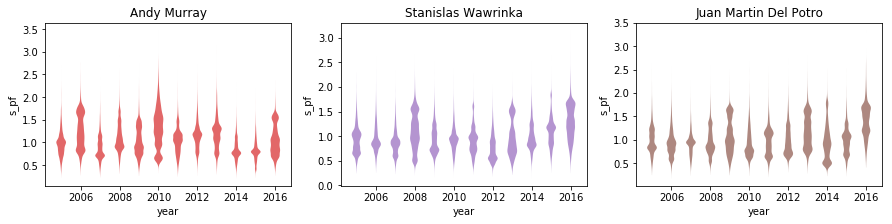

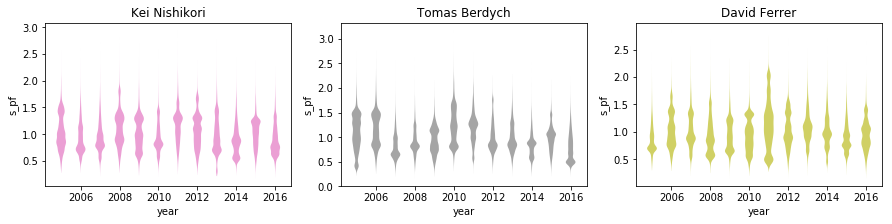

In [21]:
# Uneven performance

plot_posterior_dist_ts_ply(
    arr_target_year=ARR_TARGET_YEAR,
    arr_target_player=ARR_TARGET_PLAYER,
    la=la_ts,
    target_param="s_pf",
)

<h2>Insights</h2>

* マレーが、年によって勝負ムラが大きくなるような結果
* ワウリンカは、直近（2015〜2017.02）は勝負ムラが大きかったものの、それまでの年で言えば、比較的大きくなかった模様
* 錦織は、直近（2015〜2017.02）の分析と同様、勝負ムラはあまり大きくない傾向にあり、勝つ相手には勝つ、負ける相手には負けるがハッキリしている様子

<br>
==============<br>
<br>

* Murray's results, where the uneven performance seems to increase from year to year.
* Wawrinka's uneven performance was large in the most recent years (2015-2017.02), but in previous years, it was relatively small.
* Nishikori, as in the most recent analysis (2015-2017.02), tends not to have much uneven performance, and seems to clearly win against opponents who win and lose against opponents who lose.

<br>

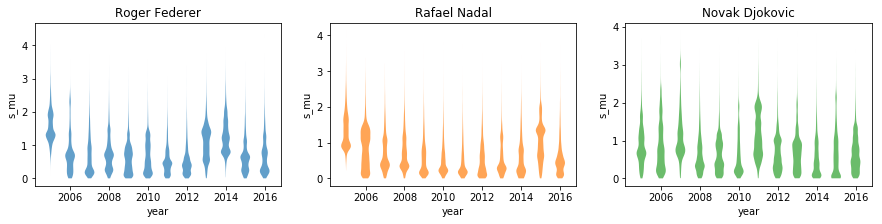

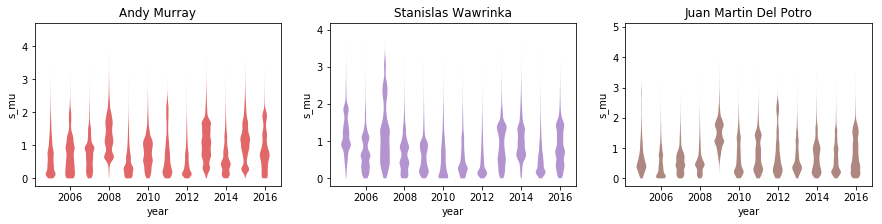

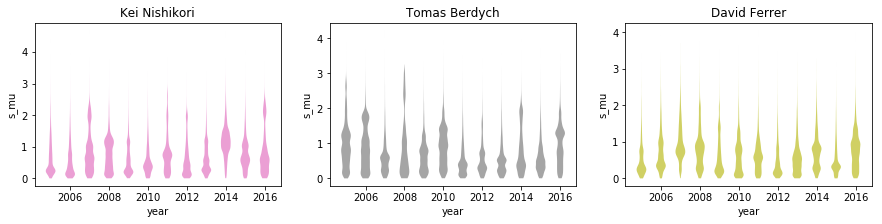

In [22]:
# Change of strength

plot_posterior_dist_ts_ply(
    arr_target_year=ARR_TARGET_YEAR,
    arr_target_player=ARR_TARGET_PLAYER,
    la=la_ts,
    target_param="s_mu",
)

<h2>Insights</h2>

* 基本的には、強さの時系列のモデルの傾きと、大きさが連動している
* 初年度は 0 から推定させていることもあり、元から強かったフェデラー、ナダルがいきなり強くなっているように見える
* マレーは、フェデラー、ナダルに勝つようになった上向きの強さの変化と、不調による下向きの強さの変化が見える
* デル・ポトロは、2009年で強さが大きく変化していることがわかる
* 錦織は、2014年で強さが大きく変化していることがわかる

<br>
==============<br>
<br>

* Basically, the magnitude is linked to the slope of the strength time series model
* Federer and Nadal, who were originally strong, appear to have suddenly become stronger, partly because they are estimated from 0 in the first year.
* Murray's upward strength change that led him to beat Federer and Nadal, and downward strength change due to his poor performance are seen.
* Del Potro shows a significant change in strength in 2009.
* Nishikori shows a significant change in strength in 2014

<br>

In [23]:
!pip freeze > requirements.txt
!python --version > py_ver.txt

Python 3.6.6 :: Anaconda custom (64-bit)
